In [23]:
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from scipy.stats import wasserstein_distance, gaussian_kde
import seaborn as sns
from scipy.stats import skew, kurtosis
import gymnasium as gym
from gymnasium import spaces
from torch.nn import functional as F
from sb3_contrib import RecurrentPPO
from typing import Callable
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
sns.set_style("whitegrid", rc={"grid.alpha": 0.5})

FUNCTIONS

In [24]:
def ar_p_simulator_with_deltas(n, m, phi, drift, sigma):

    AR_prices = []
    AR_deltas = []
    
    # Construct the AR and MA coefficient vectors
    ar = np.array([1] + [-coeff for coeff in phi])  # AR coefficients with 1 at the beginning
    ma = np.array([1])  # MA coefficients (no moving average, so this is just [1])
    
    for _ in range(m):

        arma_process = ArmaProcess(ar, ma)
        simulated_values = arma_process.generate_sample(nsample=n)
        # Add drift to the simulated values
        simulated_values += drift * np.arange(n)
        # Scale the simulated values by the noise standard deviation
        AR_price = simulated_values * sigma
        AR_delta = np.diff(AR_price)
        
        AR_prices.append(AR_price)
        AR_deltas.append(AR_delta)
    
    return np.array(AR_prices), np.array(AR_deltas)

def tokenize_deltas(data, bin_start, bin_stop, bin_width):
    
    # Assuming data is a NumPy array of shape (n_sequences, seq_length)
    n_sequences, _ = data.shape

    # Bin range and Bin width
    num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
    bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Tokenize each sequence individually (no flattening)
    tokenized_sequences = np.empty_like(data)
    
    for i in range(n_sequences):
        tokenized_data = np.digitize(data[i], bins=bin_edges, right=False) - 1
        tokenized_sequences[i] = np.clip(tokenized_data, 0, num_bins - 1)

    return tokenized_sequences




PLOT FUNCTIONS

In [25]:
def plot_price_hist(price, deltas, bin_start, bin_stop, bin_width):
    fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

    # Histogram: GBM Prices
    axs[0].hist(np.concatenate(price), bins=20, color='blue', density=True)
    axs[0].set_title('Histogram: AR Prices')
    axs[0].set_xlabel('Price')
    axs[0].set_ylabel('Frequency')

    bins = np.arange(bin_start, bin_stop + bin_width, bin_width)

    # Histogram: GBM Price Deltas
    axs[1].hist(np.concatenate(deltas), 
                bins=bins, 
                edgecolor='orange', color='blue', density=True)
    axs[1].set_title('Histogram: AR Price Deltas')
    axs[1].set_xlabel('Price Difference')
    axs[1].set_ylabel('Frequency')

    # Boxplot Price Deltas
    axs[2].boxplot(np.concatenate(deltas), vert=False)
    axs[2].set_title('Boxplot Price Deltas')
    axs[2].set_xlabel('Price Difference')
    plt.tight_layout()
    plt.show()

def supervised_wasserstein(real_data, supervised_data):
    n_timesteps = real_data.shape[1]
    
    # Calculate Wasserstein distance for each timestep
    wasserstein_supervised = []
    
    for t in range(n_timesteps):
        w_dist = wasserstein_distance(real_data[:, t], supervised_data[:, t])
        wasserstein_supervised.append(w_dist)

    # Create visualization
    fig = plt.figure(figsize=(10, 3.5))
    
    # 1. Main grid for plots
    gs = plt.GridSpec(1, 2)
    # Plot 1: Wasserstein distances over time
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(wasserstein_supervised, label = "Supervised")
    ax1.set_title('Wasserstein Distance by Timestep')
    ax1.set_xlabel('Timestep')
    ax1.set_ylabel('Wasserstein Distance')
    ax1.legend()

    # Plot 2: Compare specific timesteps
    ax2 = fig.add_subplot(gs[0, 1])
    # Pick timestep with largest Wasserstein distance
    worst_timestep_supervised = np.argmax(wasserstein_supervised)

    # Get data for the specified timestep
    real_data = real_data[:, worst_timestep_supervised]
    generated_data = supervised_data[:, worst_timestep_supervised]

    # Calculate KDE
    kde_real = gaussian_kde(real_data)
    kde_generated = gaussian_kde(generated_data)

    # Create evaluation points
    x_eval = np.linspace(min(real_data.min(), generated_data.min()),
                        max(real_data.max(), generated_data.max()),
                        200)
    
    # Plot distributions
    ax2.plot(x_eval, kde_real(x_eval), label='Real', color='blue')
    ax2.plot(x_eval, kde_generated(x_eval), label='Supervised', color='red')
    ax2.set_title(f'Distribution Comparison at Timestep {worst_timestep_supervised}\n'
                f'(Largest Wasserstein Distance)')
    ax2.legend()


$X_t = \mu + 0.6X_{t-1} + 0.4X_{t-2} + 0.3X_{t-3} + 0.1 + \epsilon_t, \quad \epsilon_t \sim N(0, 1)$

**SETTINGS**

In [38]:
phi = [0.6, 0.4, 0.3]       # AR coefficients for positive skew    
drift = 0.1                 # Drift term (constant increment per step)
sigma = 1                   # Standard deviation of noise

n_days = 32                 # Length of each sequence
n_sequences = 30000         # Number of Sequences for training

In [39]:
Price_AR, Delta_AR = ar_p_simulator_with_deltas(n = n_days, m = n_sequences, phi=phi, drift=drift, sigma=sigma)
print('Standard Deviation of Price Deltas:', np.round(np.std(np.concatenate(Delta_AR)),3))

Standard Deviation of Price Deltas: 6.581


**SETTINGS**

In [40]:
bin_width = 0.65
bin_start=-25
bin_stop=25
token_size = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins

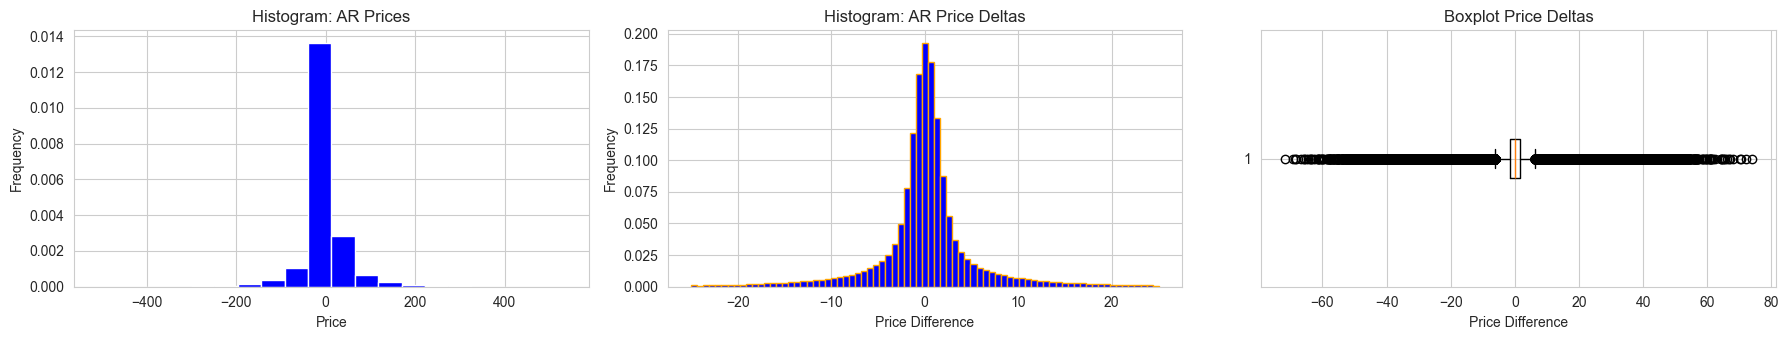

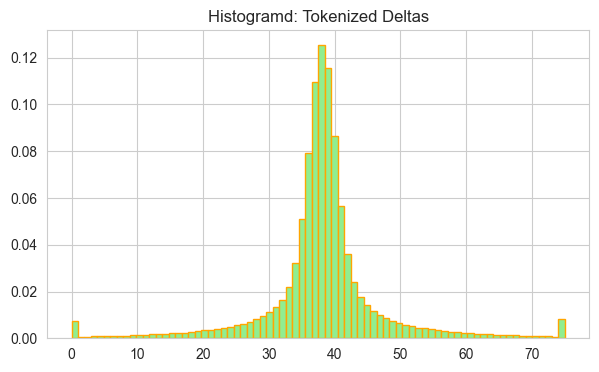

Number of Tokens: 76
Data Shape: (30000, 31)


In [46]:
plot_price_hist(Price_AR, Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

plt.figure(figsize=(7,4))
plt.hist(np.concatenate(tokenize_deltas(Delta_AR, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)), bins=token_size, density=True, color='lightgreen', edgecolor='orange')
plt.title('Histogramd: Tokenized Deltas')
plt.show()

print('Number of Tokens:', token_size)
print('Data Shape:', Delta_AR.shape)

In [42]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):  # Changed default input_dim
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden):
        # x shape now: [batch_size, sequence_length, vocab_size]
        lstm_out, (h_n, c_n) = self.lstm(x, hidden)
        logits = self.fc(lstm_out)
        return logits, (h_n, c_n)

def to_onehot(tokens, vocab_size):
    """Convert batch of tokens to one-hot vectors"""
    # tokens shape: [batch_size, sequence_length]
    batch_size, seq_length = tokens.shape
    onehot = th.zeros(batch_size, seq_length, vocab_size)
    for i in range(batch_size):
        for j in range(seq_length):
            onehot[i, j, tokens[i, j]] = 1
    return onehot

**SETTINGS**

In [43]:
# Rest of your parameters remain the same
hidden_dim = 256
batch_size = 512
learning_rate = 0.001
seq_len = n_days-1
num_epochs = 50

In [44]:
# Create model with new input dimension
model_supervised = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)

criterion_supervised = nn.CrossEntropyLoss()
optimizer = th.optim.Adam(model_supervised.parameters(), lr=learning_rate)

train_loss = []
best_loss = float('inf')
max_grad_norm = 1.0

for epoch in range(num_epochs):
    model_supervised.train()
    temp_loss = []

    # Generate fresh data (this stays the same)
    _, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
    train_data = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

    for batch_idx in range(0, len(train_data), batch_size):
        batch = train_data[batch_idx:batch_idx + batch_size]
        
        # Main changes here: convert inputs to one-hot
        input_tokens = th.tensor(batch[:, :-1], dtype=th.long)  # Changed to long type
        inputs = to_onehot(input_tokens, token_size)  # Convert to one-hot
        targets = th.tensor(batch[:, 1:], dtype=th.long)
        
        logits, _ = model_supervised(inputs, None)
        logits = logits.view(-1, logits.size(-1))
        targets = targets.view(-1)
        
        loss = criterion_supervised(logits, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        th.nn.utils.clip_grad_norm_(model_supervised.parameters(), max_grad_norm)
        
        optimizer.step()
        
        temp_loss.append(loss.item())

        if loss.item() < best_loss:
            best_loss = loss.item()
            th.save(model_supervised.state_dict(), 'supervised_training_weights.pth')
    
    train_loss.extend(temp_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {np.mean(temp_loss):.4f}")

Epoch 1/50 - Train Loss: 3.3571
Epoch 2/50 - Train Loss: 2.5401
Epoch 3/50 - Train Loss: 2.3290
Epoch 4/50 - Train Loss: 2.0828
Epoch 5/50 - Train Loss: 1.9931
Epoch 6/50 - Train Loss: 1.9825
Epoch 7/50 - Train Loss: 1.9637
Epoch 8/50 - Train Loss: 1.9564
Epoch 9/50 - Train Loss: 1.9502
Epoch 10/50 - Train Loss: 1.9276
Epoch 11/50 - Train Loss: 1.9218
Epoch 12/50 - Train Loss: 1.9146
Epoch 13/50 - Train Loss: 1.9081
Epoch 14/50 - Train Loss: 1.9020
Epoch 15/50 - Train Loss: 1.9005
Epoch 16/50 - Train Loss: 1.8966
Epoch 17/50 - Train Loss: 1.8911
Epoch 18/50 - Train Loss: 1.8908
Epoch 19/50 - Train Loss: 1.8931
Epoch 20/50 - Train Loss: 1.8903
Epoch 21/50 - Train Loss: 1.8879
Epoch 22/50 - Train Loss: 1.8911
Epoch 23/50 - Train Loss: 1.8872
Epoch 24/50 - Train Loss: 1.8863
Epoch 25/50 - Train Loss: 1.8870
Epoch 26/50 - Train Loss: 1.8833
Epoch 27/50 - Train Loss: 1.8857
Epoch 28/50 - Train Loss: 1.8828
Epoch 29/50 - Train Loss: 1.8822
Epoch 30/50 - Train Loss: 1.8835
Epoch 31/50 - Train

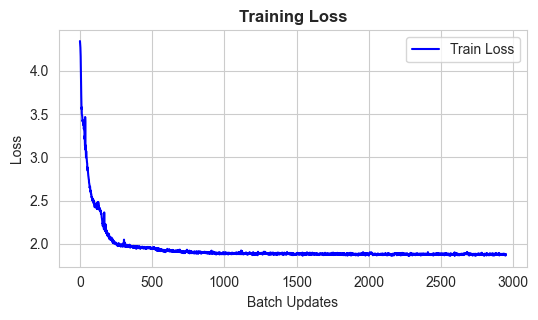

In [45]:
# Create the plot
plt.figure(figsize=(5.5, 3.3))
plt.plot(train_loss, label='Train Loss', color='blue', linewidth=1.5)
plt.title('Training Loss', fontweight='bold')
plt.xlabel('Batch Updates')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10, frameon=True)
plt.tight_layout()
plt.show()

### Supervised Inference

In [47]:
_, price_deltas = ar_p_simulator_with_deltas(n=n_days, m=n_sequences, phi=phi, drift=drift, sigma=sigma)
test_data = tokenize_deltas(price_deltas, bin_start=bin_start, bin_stop=bin_stop, bin_width=bin_width)

# Update model creation to match new architecture
inference_model = LSTMModel(input_dim=token_size, hidden_dim=hidden_dim, output_dim=token_size)
inference_model.load_state_dict(th.load('supervised_training_weights.pth', weights_only=False))

test_data_inference = th.tensor(test_data, dtype=th.long)  # Changed to long type

test_losses = []
supervised_data = []

inference_model.eval()

def to_onehot_single(token, vocab_size):
    """Convert single token to one-hot vector"""
    onehot = th.zeros(vocab_size)
    onehot[token.long()] = 1
    return onehot

with th.no_grad():
    for sequence in test_data_inference:
        token_loss = 0
        
        init_real_token = sequence[0]
        sim_trajectory = [init_real_token]
        
        hidden = None
        
        for i in range(1, len(sequence)):
            # Convert last token to one-hot
            last_token = sim_trajectory[-1]
            input_onehot = to_onehot_single(last_token, token_size).reshape(1, 1, -1)
            
            logits, hidden = inference_model(input_onehot, hidden)
            
            probs = F.softmax(logits, dim=-1).squeeze()
            predicted_token = th.multinomial(probs, num_samples=1).squeeze()
            
            sim_trajectory.append(predicted_token.float())
            
            # Loss calculation
            true_token = sequence[i].unsqueeze(-1)
            loss = criterion_supervised(logits.squeeze(1), true_token.long())
            token_loss += loss.item()
        
        test_losses.append(token_loss/len(sequence))
        supervised_data.append(sim_trajectory[1:])

supervised_data = np.array(supervised_data)

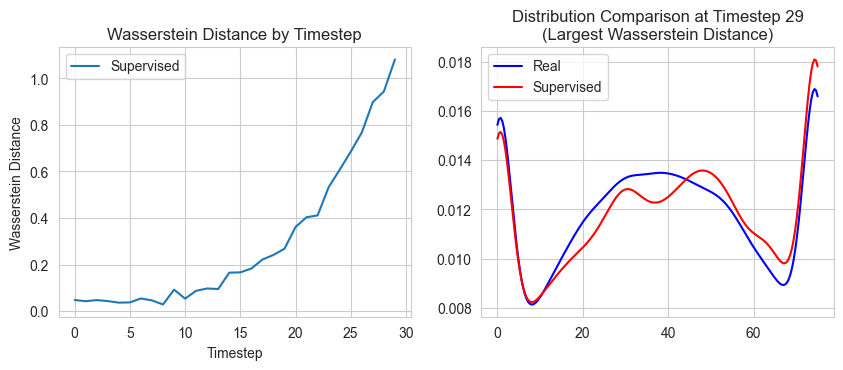

In [48]:
supervised_wasserstein(test_data[:,1:], supervised_data)

### GAIL

In [ ]:
class LSTM_Discriminator(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(LSTM_Discriminator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=3, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        logits = self.fc(lstm_out)
        logits = logits.squeeze(-1)
        return logits, hidden